<a href="https://colab.research.google.com/github/finardi/IA376A/blob/master/IMDB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Nome: Paulo Finardi

- **IMDB Week4**


## Bibliotecas e Fç para fazer testes pseudo determínisticos

In [ ]:
!pip install -q  nltk

import re
import torch 
import torch.nn as nn
import torch.nn.functional as F
from collections import Counter
import numpy as np
import nltk
nltk.download('punkt')

manualSeed = 0

def deterministic(rep=True):
  if rep:
    np.random.seed(manualSeed)
    torch.manual_seed(manualSeed)
    if torch.cuda.is_available():
      torch.cuda.manual_seed(manualSeed)
      torch.cuda.manual_seed_all(manualSeed)
    torch.backends.cudnn.enabled = False 
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    print(f'Deterministic experiment, seed: {manualSeed}')
  else:
    print('Random experiment')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
Using device: cuda


# Download IMDB dataset 
- fast.ai


In [ ]:
!wget -nc http://files.fast.ai/data/examples/imdb_sample.tgz
!tar -xzf imdb_sample.tgz

--2020-03-29 13:36:07--  http://files.fast.ai/data/examples/imdb_sample.tgz
Resolving files.fast.ai (files.fast.ai)... 67.205.15.147
Connecting to files.fast.ai (files.fast.ai)|67.205.15.147|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 571827 (558K) [application/x-gtar-compressed]
Saving to: ‘imdb_sample.tgz’

imdb_sample.tgz     100%[===================>] 558.42K  1.70MB/s    in 0.3s    

2020-03-29 13:36:08 (1.70 MB/s) - ‘imdb_sample.tgz’ saved [571827/571827]



In [ ]:
import pandas as pd

df = pd.read_csv('imdb_sample/texts.csv')
print(df.shape)
df['label'] = df['label'].copy()

# Coluna lábel para numérica
df['label'] = df['label'].map({'negative': int(0), 'positive': int(1)})
df.head()

(1000, 3)


,label,text,is_valid
0,0,Un-bleeping-believable! Meg Ryan doesn't even ...,False
1,1,This is a extremely well-made film. The acting...,False
2,0,Every once in a long while a movie will come a...,False
3,1,Name just says it all. I watched this movie wi...,False
4,0,This movie succeeds at being one of the most u...,False


There are 524 samples of Negative class.       
There are 476 samples of Positive class.     


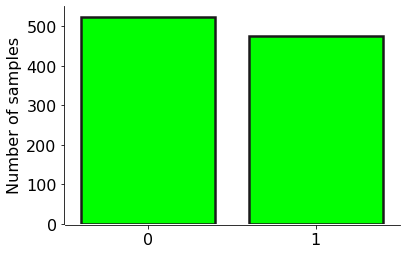

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

""" Exploration of number of samples classes """

# plot
ax = sns.barplot(df.label.unique(), df.label.value_counts(), 
                 linewidth=2.5, facecolor=(0, 1, 0), edgecolor=".1")

# decoração
sns.despine(offset=1, trim=False)
sns.set_style("ticks")
ax.set_ylabel('Number of samples', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.rcParams['figure.figsize'] = (10,3)

print(f'There are {df.label.value_counts().tolist()[0]} samples of Negative class.\
       \nThere are {df.label.value_counts().tolist()[1]} samples of Positive class.\
     ')

# Classes / fçs comuns as implementações do BoW TF-IDF e Embedding pré treinados



In [ ]:
from torch.utils.data import Dataset, DataLoader

# Classe que cria o dataset
class ImdbDataset(Dataset):
  def __init__(self, csv_path):
    super(ImdbDataset, self).__init__()
    data = pd.read_csv(csv_path, index_col=0)
    
    self.target =  data.label.to_numpy().copy()
    self.x      =  data.drop(['label'], axis=1).to_numpy().copy()

    self.target = torch.from_numpy(self.target).type(torch.LongTensor)
    self.x      = torch.from_numpy(self.x).type(torch.FloatTensor)

  def __len__(self):
    return self.x.shape[0]
  
  def __getitem__(self, index):
    return self.x[index], self.target[index]

## Label Smoothing and Optim
- details in this [paper:](https://arxiv.org/pdf/1906.02629.pdf)

In [ ]:
import torch.nn as nn
# Método de regularização
class LabelSmoothing(nn.Module):
  def __init__(self, smoothing = 0.1):
    assert 0.0 <= smoothing < 1.0, f"got smoothing={smoothing}"
    super(LabelSmoothing, self).__init__()
    self.smoothing = smoothing

  def forward(self, input, target):
    target = target.detach()
    log = F.log_softmax(input, dim=1)
    oh = torch.ones_like(input).detach_()*(self.smoothing/input.size(1))
    oh = oh.scatter_(1, target.unsqueeze(1),
                      (1.0 - self.smoothing + self.smoothing/input.size(1)))
    return ((-oh*log).sum(dim=1).mean())

## Train and Eval functions

In [ ]:
from sklearn.metrics import accuracy_score

def train(model, device, train_loader, loss_fn, optimizer):
  model.train()
  loss_train = []
  for data, target in train_loader:
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()
    output = model(data)
    loss = loss_fn(output, target)
    loss_train.append(loss.item())
  
    loss.backward()
    optimizer.step()
  
  ave_train_loss = sum(loss_train) / len(loss_train)
  return ave_train_loss, np.exp(ave_train_loss)

def test(model, device, valid_loader, loss_fn):
  model.eval()
  logits, trues, loss_test = [],[],[]
  with torch.no_grad():
    for data, target in valid_loader:
      data, target = data.to(device), target.to(device)
      output = model(data)
      loss = loss_fn(output, target)
      loss_test.append(loss.item())
      
      logits.extend(output.to('cpu').numpy().tolist())
      trues.extend(target.to('cpu').numpy().tolist())
      prob = F.softmax(torch.tensor(logits), dim=1).numpy().copy()
      probs = prob[:,1]
  
    ave_test_loss = sum(loss_test) / len(loss_test)
  return ave_test_loss, np.exp(ave_test_loss), accuracy_score(trues, probs.round()) 

# Processamento do texto

In [ ]:
REP_SEM_SPACE = re.compile("(\.)|(\;)|(\:)|(\!)|(\')|(\?)|(\,)|(\")|(\()|(\))|(\[)|(\])")
REP_COM_SPACE = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)")

In [ ]:
def preprocess_reviews(reviews):
    reviews = [REP_SEM_SPACE.sub("", r.lower()) for r in reviews]
    reviews = [REP_COM_SPACE.sub(" ", r) for r in reviews]
    return reviews

In [ ]:
reviews_clean = preprocess_reviews(df.text.to_list())

In [ ]:
reviews_tokenized = [nltk.word_tokenize(review) for review in reviews_clean] # tokenização

## Palavras mais frequentes

In [ ]:
import itertools

# Extrair as palavras das reviews positivas
pos_words = [reviews_tokenized[i] for i in range(len(reviews_tokenized)) if df.label.to_list()[i] == 1]
pos_words = list(itertools.chain.from_iterable(pos_words))

# Extrair as palavras das reviews negativas
neg_words = [reviews_tokenized[i] for i in range(len(reviews_tokenized)) if df.label.to_list()[i] == 0]
neg_words = list(itertools.chain.from_iterable(neg_words))

In [ ]:
nltk.download('stopwords')

# Remover stop words
stop_words = set(nltk.corpus.stopwords.words('english'))
stop_words.add('movie')
stop_words.add('film')
stop_words.add('character')
stop_words.add('characters')
stop_words.add('br')
pos_words_final = [word for word in pos_words if word not in stop_words]
neg_words_final = [word for word in neg_words if word not in stop_words]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Calcular a frequência das distribuições das palavras nas reviews positivas e negativas
fd_pos = nltk.FreqDist(p for p in pos_words_final)
fd_neg = nltk.FreqDist(n for n in neg_words_final)

In [ ]:
most_common_pos = fd_pos.most_common(30) # 30 palavras mais comuns na review positiva
most_common_neg = fd_neg.most_common(30) # 30 palavras mais comuns na review negativa

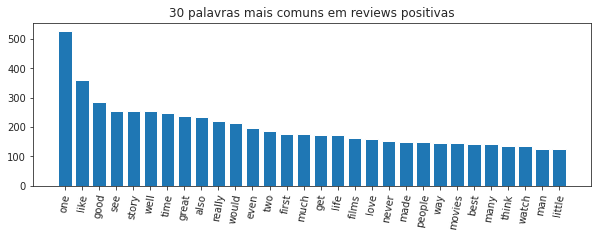

In [ ]:
plt.bar(range(len(most_common_pos)), [val[1] for val in most_common_pos])
plt.xticks(range(len(most_common_pos)), [val[0] for val in most_common_pos])
plt.xticks(rotation=80)
plt.title('30 palavras mais comuns em reviews positivas')
plt.show()

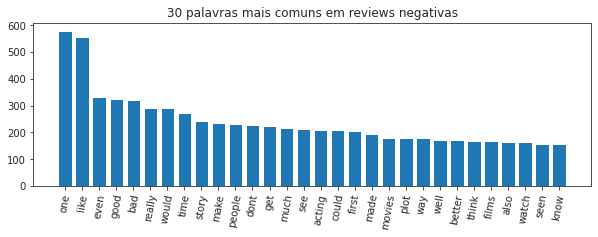

In [ ]:
plt.bar(range(len(most_common_neg)), [val[1] for val in most_common_neg])
plt.xticks(range(len(most_common_neg)), [val[0] for val in most_common_neg])
plt.xticks(rotation=80)
plt.title('30 palavras mais comuns em reviews negativas')
plt.show()

In [ ]:
# Verificando a interseção das palavras que aparecem nas reviews positivas e negativas
inter = list(set(pos_words_final).intersection(set(neg_words_final)))
print(f'Existem: {len(inter)} words comuns nas reviews positivas e Negativas.\n\
        As 10ª são: {inter[:10]}')

Existem: 6774 words comuns nas reviews positivas e Negativas.
        As 10ª são: ['wedding', 'orders', 'shadows', 'drugs', 'humble', 'stories', 'besides', 'omar', 'someplace', 'freudian']


## Removendo stop words

In [ ]:
""" Removendo stop words """
tokenized_processed = []
for i in range(len(reviews_tokenized)):
  review = []
  for j in reviews_tokenized[i]:
    if j not in stop_words: 
      review.append(j)
  tokenized_processed.append(review)

print(f'Texto tokenizado e limpo: {tokenized_processed[:1]}')

Texto tokenizado e limpo: [['un', 'bleeping', 'believable', 'meg', 'ryan', 'doesnt', 'even', 'look', 'usual', 'pert', 'lovable', 'self', 'normally', 'makes', 'forgive', 'shallow', 'ticky', 'acting', 'schtick', 'hard', 'believe', 'producer', 'dog', 'plus', 'kevin', 'kline', 'kind', 'suicide', 'trip', 'career', 'whoosh', 'banzai', 'finally', 'directed', 'guy', 'big', 'chill', 'must', 'replay', 'jonestown', 'hollywood', 'style', 'wooofff']]


In [ ]:
reviews = [' '.join(t) for t in tokenized_processed] # juntando as reviews ()
reviews[2]

'every long come along awful feel compelled warn people labor days save one soul watching great joy begin discussion pain starters musical montage every five minutes development every stereotype swearing guy fat guy eats donuts goofy foreign guy etc script felt written shot production value incredibly low felt like watching junior high video presentation directors producers etc ever even seen halestorm getting worse worse every new entry concept sounded funny could go wrong gary coleman handful somewhat legitimate actors trust say things went wrong wrong'

In [ ]:
labels = df.label.to_list() # labels 

# MLP com TF-IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from torch.utils.data import TensorDataset
from sklearn.model_selection import train_test_split

In [ ]:
# Essa função é o Tfid que faz o BoW
def encoder_BoW(X_train,X_test):
  tfid = TfidfVectorizer()
  tfid.fit(X_train)
  return tfid.transform(X_train), tfid.transform(X_test)

In [ ]:
train_X, test_X, train_y, test_y = train_test_split(reviews, 
                                                    labels, 
                                                    shuffle=True, 
                                                    test_size=0.2, 
                                                    random_state=123)

In [ ]:
X_train, X_test = encoder_BoW(train_X, test_X) 

In [ ]:
# Cria o dataset (Pandas DF) de treino
df_train = pd.DataFrame(X_train.toarray())
df_train['label'] = train_y
cols = df_train.columns.tolist()
cols = cols[-1:] + cols[:-1]
df_train = df_train[cols]

# Cria o dataset (Pandas DF) de teste
df_test = pd.DataFrame(X_test.toarray())
df_test['label'] = test_y
cols = df_test.columns.tolist()
cols = cols[-1:] + cols[:-1]
df_test = df_test[cols]

In [ ]:
# Eu escolhi salvar e chamar os conj. de dados para minha classe dataset 
df_train.to_csv('train.csv')
df_test.to_csv('test.csv')

df_train = pd.read_csv('train.csv',index_col=0)
df_test  = pd.read_csv('test.csv', index_col=0)

print(f'df_train.shape: {df_train.shape}') 
print(f'df_test.shape: {df_test.shape}') 

# teste de sanidade:
trn = pd.read_csv('train.csv', index_col=0)
trn.head()

df_train.shape: (800, 17300)
df_test.shape: (200, 17300)


,label,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,17259,17260,17261,17262,17263,17264,17265,17266,17267,17268,17269,17270,17271,17272,17273,17274,17275,17276,17277,17278,17279,17280,17281,17282,17283,17284,17285,17286,17287,17288,17289,17290,17291,17292,17293,17294,17295,17296,17297,17298
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.124306,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.038289,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.06225,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## ImdbDataset Class


In [ ]:
from torch.utils.data import Dataset, DataLoader

# Classe que cria o dataset
class ImdbDataset(Dataset):
  def __init__(self, csv_path):
    super(ImdbDataset, self).__init__()
    data = pd.read_csv(csv_path, index_col=0)
    
    self.target =  data.label.to_numpy().copy()
    self.x      =  data.drop(['label'], axis=1).to_numpy().copy()

    self.target = torch.from_numpy(self.target).type(torch.LongTensor)
    self.x      = torch.from_numpy(self.x).type(torch.FloatTensor)

  def __len__(self):
    return self.x.shape[0]
  
  def __getitem__(self, index):
    return self.x[index], self.target[index]

In [ ]:
# teste de sanidade:
ds = ImdbDataset('train.csv')
x0, y0 = ds[4]
x0, y0

(tensor([0., 0., 0.,  ..., 0., 0., 0.]), tensor(1))

In [ ]:
# teste de sanidade:
train_loader = DataLoader(ds, 100, shuffle=False)
x, y = next(iter(train_loader))

print(f'input shape: {x.shape}') 
print(f'label shape: {y.shape}')

input shape: torch.Size([100, 17299])
label shape: torch.Size([100])


# Modelo MLP

In [ ]:
class MLP(nn.Module):
  def __init__(self, vocab_dim, neur1, neur2, drop, out):
    super(MLP, self).__init__()
    
    self.norm0 = nn.LayerNorm(vocab_dim) # <- norm. do dado de entrada
    self.drop = nn.Dropout(drop)
    self.relu = nn.ReLU() 
    
    self.fc0 = nn.Linear(vocab_dim, neur1)
    self.fc1 = nn.Linear(neur1, neur2)
    self.fc2 = nn.Linear(neur2, out) 

  def forward(self, x):
    o = self.norm0(x)
    o = self.drop(self.relu(self.fc0(o)))
    o = self.drop(self.relu(self.fc1(o)))
    return self.fc2(o)

### Glorot init para os pesos e zero init para os bias

In [ ]:
# pesos iniciados com valores (0,std²)
def weights_init(m):
  if isinstance(m, nn.Linear):
    torch.nn.init.xavier_normal_(m.weight.data, gain=nn.init.calculate_gain('relu'))
    torch.nn.init.zeros_(m.bias.data)

In [ ]:
# Hyperparams do modelo
VOCAB_SIZE, H1,H2,D,O, = df_train.shape[1] -1, 70, 39, 0.5, df.label.nunique()

model       = MLP(VOCAB_SIZE, H1, H2, D, O)
# model.apply(weights_init)

# teste de sanidade:
x,y = next(iter(train_loader))
model(x).shape

torch.Size([100, 2])

## Dataloaders, Minibatches and Criterion


In [ ]:
BATCH_SIZE = 20

# Cria datasets (train / valid)
dataset_train  = ImdbDataset('train.csv')
dataset_valid  = ImdbDataset('test.csv')

# Cria o dataloder_bow de treino
train_loader_bow = DataLoader(dataset=dataset_train, batch_size=BATCH_SIZE, shuffle=True)

# Cria o dataloader_bow de valid
valid_loader_bow = DataLoader(dataset=dataset_valid, batch_size=BATCH_SIZE, shuffle=False)                       

print(len(train_loader_bow), len(valid_loader_bow))

40 10


# Busca de hyperparams - Optuna


In [ ]:
!pip install -q optuna
!pip install -q torch_optimizer
import torch_optimizer as optim
import optuna
from optuna.samplers import RandomSampler

     |████████████████████████████████| 153kB 33.7MB/s 
     |████████████████████████████████| 1.1MB 47.4MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 81kB 11.7MB/s 
     |████████████████████████████████| 81kB 12.1MB/s 
     |████████████████████████████████| 51kB 8.1MB/s 
     |████████████████████████████████| 61kB 10.0MB/s 
     |████████████████████████████████| 112kB 65.3MB/s 


In [ ]:
EPOCH = 10

# Função trial que busca o melhor optmin e a melhor lr
def get_optimizer(trial, model):
    optimizer_name = trial.suggest_categorical('optimizer', ['AdaMod', 'Yogi'])
    lr_optmzd = trial.suggest_uniform('optim_lr', 3*1e-4, 2*1e-3)
    return getattr(optim, optimizer_name)(model.parameters(), lr=lr_optmzd)

# Função obj que tenta max a acurácia
def objective(trial):
  h1     = int(trial.suggest_uniform("h1_units", 60, 90))
  h2     = int(trial.suggest_uniform("h2_units", 20, 50))
  drop   = trial.suggest_uniform("drop", 0.2, 0.7)
  smooth = trial.suggest_uniform("smooth", 0.1, 0.35)
  
  criterion = LabelSmoothing(smooth)     
  model     = MLP(VOCAB_SIZE, h1, h2, drop, O).to(device)
  model.apply(weights_init)    
  optimizer = get_optimizer(trial, model)

  for step in range(EPOCH):
    loss_train, _ = train(model, device, train_loader_bow, criterion, optimizer)
    loss_valid, _, acc = test(model, device, valid_loader_bow, criterion)

  return acc

In [ ]:
deterministic() # <- ter certeza que tudo foi zerado para o teste ser reproduzível

# Running optuna
study = optuna.create_study(direction='maximize', sampler=RandomSampler(manualSeed))
study.optimize(objective, n_trials=200)
print('Number of finished trials: ', len(study.trials))
print('Best trial:')
trial = study.best_trial
print('  Value: ', trial.value)
print('  Params: ')

for key, value in trial.params.items():
    print(f'    {key}: {value}')

In [ ]:
# Melhor conj. de params encontrado
study.best_params

{'drop': 0.358600871034648,
 'h1_units': 70.14022844516676,
 'h2_units': 40.242569667770624,
 'optim_lr': 0.0009268327901236391,
 'optimizer': 'Yogi',
 'smooth': 0.29458637050647724}

## Optuna Visualization
- nice plots

In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
optuna.visualization.plot_parallel_coordinate(study)

# Testando a melhor configuração encontrada

In [ ]:
# Melhor params dict
study.best_params

{'drop': 0.358600871034648,
 'h1_units': 70.14022844516676,
 'h2_units': 40.242569667770624,
 'optim_lr': 0.0009268327901236391,
 'optimizer': 'Yogi',
 'smooth': 0.29458637050647724}

In [ ]:
deterministic() 

# Configura o melhor setup encontrado pelo Optuna
H1     = int(study.best_params['h1_units'])
H2     = int(study.best_params['h2_units'])
D      = study.best_params['drop']
SMOOTH = study.best_params['smooth']
LR     = study.best_params['optim_lr']

model = MLP(VOCAB_SIZE, H1, 39, D, O).to(device)
model.apply(weights_init)    
criterion = LabelSmoothing(SMOOTH)

if study.best_params['optimizer'] == 'Yogi':
  print(f'Using {study.best_params["optimizer"]}')
  optimizer = optim.Yogi(model.parameters(),lr= LR)  
else:
  print(f'Using {study.best_params["optimizer"]}')
  optimizer = optim.AdaMod(model.parameters(),lr= LR)  

print(model)

# Count params
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'\n################################################\
       \n# The model has {count_parameters(model):,} trainable parameters #\
       \n################################################')  

Deterministic experiment, seed: 0
Using Yogi
MLP(
  (norm0): LayerNorm((17299,), eps=1e-05, elementwise_affine=True)
  (drop): Dropout(p=0.358600871034648, inplace=False)
  (relu): ReLU()
  (fc0): Linear(in_features=17299, out_features=70, bias=True)
  (fc1): Linear(in_features=70, out_features=39, bias=True)
  (fc2): Linear(in_features=39, out_features=2, bias=True)
)

################################################       
# The model has 1,248,447 trainable parameters #       
################################################


In [ ]:
%%time
import os
deterministic() 

N_EPOCHS = 100
epoch, best_acc = 0,0

for step in range(1, N_EPOCHS+1):
  loss_train, ppl_train = train(model, device, train_loader_bow, criterion, optimizer)
  loss_valid, ppl_valid, acc = test(model, device, valid_loader_bow, criterion)
  if acc >= best_acc:
    best_acc = acc
    epoch    = step
    print(f'Epoch [{step}/{N_EPOCHS}] | Train Loss: {loss_train:.3f} -- Valid Loss: {loss_valid:.3f} --',end=' ')
    print(f'Acc: {acc:.3f}')
    print(f'Ppl train: {ppl_train:.3f} -- Ppl valid: {ppl_valid:.3f}\n')
   
print(f'\nEnd of training. Best Acc: -->[{best_acc:.4f}]<--, at epoch: {epoch}\n')

Deterministic experiment, seed: 0
Epoch [1/100] | Train Loss: 0.664 -- Valid Loss: 0.585 -- Acc: 0.780
Ppl train: 1.943 -- Ppl valid: 1.795

Epoch [2/100] | Train Loss: 0.502 -- Valid Loss: 0.558 -- Acc: 0.815
Ppl train: 1.653 -- Ppl valid: 1.747

Epoch [3/100] | Train Loss: 0.478 -- Valid Loss: 0.564 -- Acc: 0.835
Ppl train: 1.613 -- Ppl valid: 1.758

Epoch [4/100] | Train Loss: 0.473 -- Valid Loss: 0.575 -- Acc: 0.850
Ppl train: 1.604 -- Ppl valid: 1.777

Epoch [10/100] | Train Loss: 0.447 -- Valid Loss: 0.566 -- Acc: 0.850
Ppl train: 1.563 -- Ppl valid: 1.762

Epoch [11/100] | Train Loss: 0.448 -- Valid Loss: 0.569 -- Acc: 0.855
Ppl train: 1.565 -- Ppl valid: 1.767

Epoch [12/100] | Train Loss: 0.445 -- Valid Loss: 0.570 -- Acc: 0.860
Ppl train: 1.560 -- Ppl valid: 1.769

Epoch [13/100] | Train Loss: 0.443 -- Valid Loss: 0.571 -- Acc: 0.860
Ppl train: 1.557 -- Ppl valid: 1.770

Epoch [20/100] | Train Loss: 0.438 -- Valid Loss: 0.570 -- Acc: 0.880
Ppl train: 1.549 -- Ppl valid: 1.769

# Implementação com Embeddings glove

In [ ]:
set_vocabulary = set() # palavras únicas 
for review in tokenized_processed:
  for word in review:
    set_vocabulary.add(word)

vocab_set_size = len(set_vocabulary) # conj. de words do vocab

print(f'Set vocab size: {vocab_set_size} words') # tamanho do vocab do IMDB

Set vocab size: 19734 words


In [ ]:
# dict word2idx
idx = 0
word_to_idx = {} # dict {word:number}
for word in set_vocabulary:
  word_to_idx[word] = idx
  idx += 1

# dict idx to word
idx_to_word = {value: key for key, value in iter(word_to_idx.items())} #dict {number:word}

In [ ]:
# cria a lista de índices das sequências de cada review
sequence_reviews = []
for review in tokenized_processed:
  word_seq = []
  for word in review:
    word_seq.append(word_to_idx[word])
  sequence_reviews.append(word_seq)

## Download glove

In [ ]:
import torchtext.vocab

# glove
glove = torchtext.vocab.GloVe(name = '6B', dim = 300)
print(f'There are {len(glove.itos)} words in the vocabulary')

.vector_cache/glove.6B.zip: 862MB [06:26, 2.23MB/s]                          
100%|█████████▉| 399670/400000 [00:38<00:00, 10172.39it/s]

There are 400000 words in the vocabulary


In [ ]:
emb_dim = glove.vectors.shape[1] # dim do emb = 300 = dim do emb. do glove
emb     = np.zeros((vocab_set_size, emb_dim)) # cria um array de zeros

In [ ]:
# mapeia os embeddings do glove nas palavras do dataset IMDB
for num in range(1, len(emb)):
  word = idx_to_word[num]
  if word and re.match(r"^[a-zA-Z0-9\-]*$", word) and word in glove.stoi.keys(): 
    temp_idx = glove.stoi[word] # pega o idx da palavra no glove.stoi dict
    emb[num] = glove.vectors[temp_idx] 
  else: # o else é para o caso se não existir a palavra no glove e evitar uma quebra
    emb[num] = np.random.normal(size=(emb_dim,))

## Com a soma dos Embeddings

In [ ]:
# Somando os embeddings de cada review 
dataset_sum = []
for review in sequence_reviews:
  word_sum = np.zeros(emb_dim)
  for idx in review:
    word_sum += emb[idx]
  dataset_sum.append(word_sum)  

## Com a média dos Embeddings

In [ ]:
# Fazendo a média dos embedding de cada review
dataset_mean = []
for review in sequence_reviews:
  word_mean = np.zeros(emb_dim)
  for idx in review:
    word_mean += emb[idx]
  dataset_mean.append(word_mean)

In [ ]:
# split do dado em train=80% e test=20%
X_train_emb, X_test_emb, y_train_emb, y_test_emb = train_test_split(dataset_mean, 
                                                                    labels, 
                                                                    test_size=0.2, 
                                                                    random_state=123)

In [ ]:
# Cria o dataset (Pandas DF) de treino
df_train_emb = pd.DataFrame(X_train_emb)
df_train_emb['label'] = y_train_emb
cols = df_train_emb.columns.tolist()
cols = cols[-1:] + cols[:-1]
df_train_emb = df_train_emb[cols]

# Cria o dataset (Pandas DF) de teste
df_test_emb = pd.DataFrame(X_test_emb)
df_test_emb['label'] = y_test_emb
cols = df_test_emb.columns.tolist()
cols = cols[-1:] + cols[:-1]
df_test_emb = df_test_emb[cols]

In [ ]:
# Salva em CSV (não é a melhor forma de fazer, mas qdo o colab quebra é mais rápido de reiniciar)
df_train_emb.to_csv('train_emb.csv')
df_test_emb.to_csv('test_emb.csv')

df_train_emb = pd.read_csv('train_emb.csv',index_col=0)
df_test_emb  = pd.read_csv('test_emb.csv', index_col=0)

print(f'df_train_emb.shape: {df_train_emb.shape}') 
print(f'df_test_emb.shape: {df_test_emb.shape}') 

# teste de sanidade:
trn = pd.read_csv('train_emb.csv', index_col=0)
trn.head() # é 301 com a coluna label

df_train_emb.shape: (800, 301)
df_test_emb.shape: (200, 301)


,label,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
0,0,-1.175189,7.890260,-3.335603,-0.623612,-0.493672,4.780501,-1.118976,8.345500,-0.268218,-98.652219,8.308585,-0.845498,-6.968584,10.715902,-5.349379,-17.695685,-11.697952,-4.637259,9.044115,9.437877,13.441528,25.621982,13.948138,0.598330,-7.811959,8.302181,10.292526,-14.561384,7.036685,6.564113,-8.189259,14.378858,-25.205401,-13.822574,-65.980924,8.450704,-10.228753,3.127133,1.861251,...,2.753446,-8.488267,-6.017050,-5.913927,-0.800698,5.500927,-7.506946,-10.436810,7.356865,19.226468,8.580069,-5.825167,8.854994,0.014664,12.343413,13.278913,-118.768193,-0.553934,15.648481,-10.788418,-6.889231,1.847679,3.200727,4.155577,2.368402,5.161657,7.243918,2.182981,-7.676454,-0.832201,3.753030,-6.959814,-6.064977,1.756640,1.869142,-26.796490,4.293049,1.092765,-1.346390,5.564341
1,0,-3.325124,4.122604,-2.091796,1.704440,-1.080098,0.007943,0.703317,2.217407,2.019190,-44.418174,6.173046,-0.687947,-1.658936,7.832602,1.310181,-3.749725,0.999754,-1.707927,6.429207,9.140724,10.182271,11.903065,3.162164,-0.072153,-6.980918,0.312659,3.052520,-7.473797,4.266604,4.918511,-8.362916,4.045189,-8.796783,0.054594,-41.645077,5.693744,-6.617915,0.344042,1.879002,...,-1.010542,-5.018574,0.353384,-3.930324,-1.776730,-1.839825,0.149257,-6.029155,1.750806,10.972487,4.623418,-6.995084,3.743650,-5.144257,5.060139,-0.337170,-66.040384,5.978527,2.000124,-3.143935,-11.692010,3.664508,-0.363919,-3.321573,-3.314130,8.388756,4.152227,-1.471174,-2.609580,-6.410495,3.361549,-1.065244,-5.592382,2.081049,-5.998598,-19.252952,-1.710061,1.636862,1.525938,6.032985
2,0,-5.968698,6.109819,1.351162,-2.166283,4.843036,6.535433,-5.611836,3.233865,0.358069,-62.947103,3.532420,-1.483208,-2.571186,8.016742,-0.031484,-8.584871,-7.260515,1.360762,5.496764,5.736401,1.729584,14.500372,6.956912,5.355796,-5.028713,-1.131714,1.849990,-11.602456,8.685791,1.473613,-11.861843,11.891792,-8.586375,-4.980456,-39.153563,8.998899,-11.264067,-2.856228,-10.338615,...,5.190274,-2.366938,3.234602,1.656442,-3.229141,1.955247,-4.027668,-0.000716,0.010369,12.054717,0.500569,-4.295453,3.741223,6.252916,1.102212,-1.715822,-81.925333,-6.589124,-0.501309,-9.921314,-6.507059,-0.031098,0.422608,4.592097,-3.507558,13.131541,6.127293,-2.404148,-2.429493,2.500425,-1.493398,-4.286826,-5.707399,-1.993366,3.552865,-19.591845,2.992214,4.690124,1.108768,-0.307468
3,0,-17.704013,3.248839,-0.463489,0.066741,-0.445604,15.513841,-10.339036,6.232302,9.599130,-125.177975,5.502706,-4.742642,-4.669554,12.887255,-3.463090,-13.335997,-1.455440,-13.085422,16.931981,3.123546,14.102994,28.188383,7.255666,25.189019,-12.698952,1.831850,5.090850,-22.527845,8.152490,-5.361577,-13.652625,22.837091,-23.505551,-4.957126,-107.178161,24.194266,-11.464290,11.265455,-8.820877,...,-2.304915,-7.171077,2.200216,-7.830466,-5.492378,2.728261,10.374815,-16.043465,16.735035,17.944590,6.383995,-8.103817,13.288826,-7.609929,9.301858,3.795162,-164.076881,-5.323981,9.549318,-5.404796,-14.969718,9.098634,-4.858930,0.003711,1.193812,16.437293,4.389677,3.538050,-5.429608,-5.157111,0.036722,-5.656491,-16.752154,6.048390,-2.379699,-28.599964,-4.505762,3.603978,-0.296623,-3.579694
4,1,-40.989377,16.946282,-8.290026,-35.707902,-19.382237,22.271054,-22.587023,-7.844867,-13.060309,-234.151581,24.195289,4.870549,-27.473166,38.165710,11.335514,-21.844541,-6.554400,-20.044815,16.002340,13.515200,-9.192250,73.277540,26.322499,42.987998,-7.809791,36.099974,28.650725,-66.885000,-13.823741,66.031858,-27.130183,5.486564,-32.281351,-14.962282,-155.546311,25.804761,-14.836090,5.357022,39.215412,...,-9.817915,-19.974135,21.979366,5.247863,-19.254807,3.890525,-11.310593,-9.602268,10.451536,44.334368,37.786378,9.463019,-5.907602,-0.546631,26.048824,23.763076,-336.446495,-43.303972,2.507436,-27.93432

## Dataloaders, Minibatches and Criterion


In [ ]:
BATCH_SIZE = 20

# Cria datasets de TREINO e VALID
dataset_train  = ImdbDataset('train_emb.csv')
dataset_valid  = ImdbDataset('test_emb.csv')

# Cria dataloader das médias (ou sum) dos embeddings -  TREINO
train_loader_emb = DataLoader(dataset=dataset_train, 
                              batch_size=BATCH_SIZE, 
                              shuffle=True)

# Cria dataloader das médias (ou sum) dos embeddings -  VALID
valid_loader_emb = DataLoader(dataset=dataset_valid, 
                              batch_size=BATCH_SIZE, 
                              shuffle=False)                       

print(len(train_loader_emb), len(valid_loader_emb))

40 10


In [ ]:
a = nn.Parameter(torch.randn(BATCH_SIZE, 300).type(torch.FloatTensor))
b = nn.Parameter(torch.randn(BATCH_SIZE, 70).type(torch.FloatTensor))
print(a.T.shape, b.shape)
c = torch.einsum('ij, jk -> ik', a.T, b)
c.shape, c[:,0].shape, c[0, :].shape

torch.Size([300, 20]) torch.Size([20, 70])


(torch.Size([300, 70]), torch.Size([300]), torch.Size([70]))

## Modelo - MLPEmb

In [ ]:
class MLPEmb(nn.Module):
  def __init__(self, emb_dim, neur1, neur2, drop, out):
    super(MLPEmb, self).__init__()
    
    self.drop = nn.Dropout(drop)
    self.relu = nn.ReLU() 
    
    """ O x já é um glove embedding, então eu vou congelar essa camada 
        e colocar bias=False para nao desconfigurar o processamento"""
    self.emb = nn.Linear(emb_dim, neur1, bias=False) 
    
    self.fc1 = nn.Linear(neur1, neur2)
    self.fc2 = nn.Linear(neur2, out) 

  def forward(self, x):
    o = self.relu(self.emb(x))
    o = self.drop(self.relu(self.fc1(o)))
    return self.fc2(o)

In [ ]:
# Hyperparams do modelo MLPEmb
EMB_DIM = df_train_emb.shape[1] - 1 # -1  -> col. label
H1,H2,D,O, = 75, 22, 0.43, df.label.nunique()

model = MLPEmb(EMB_DIM, H1, H2, D, O)
x,y = next(iter(train_loader_emb))
model(x).shape

torch.Size([20, 2])

## Optuna 

In [ ]:
EPOCH = 30

# Fç trial que busca o melhor optmin e a melhor lr
def get_optimizer(trial, model):
    optimizer_name = trial.suggest_categorical('optimizer', ['AdaMod', 'Yogi'])
    lr_optmzd = trial.suggest_uniform('optim_lr', 3*1e-4, 2*1e-3)
    return getattr(optim, optimizer_name)(model.parameters(), lr=lr_optmzd)

# Fç obj que max a acc
def objective(trial):
  h1     = int(trial.suggest_uniform("h1_units", 60, 200))
  h2     = int(trial.suggest_uniform("h2_units", 20, 250))
  drop   = trial.suggest_uniform("drop", 0.2, 0.7)
  smooth = trial.suggest_uniform("smooth", 0.1, 0.35)
  
  criterion = LabelSmoothing(smooth)     
  model     = model = MLPEmb(EMB_DIM, h1, h2, drop, O).to(device)
  optimizer = get_optimizer(trial, model)

  for step in range(EPOCH):
    model.emb.weight.requires_grad = unfrozen = False
    loss_train, _ = train(model, device, train_loader_emb, criterion, optimizer)
    loss_valid, _, acc = test(model, device, valid_loader_emb, criterion)

  return acc

In [ ]:
deterministic() # <- ter certeza que tudo foi zerado para o teste ser reproduzível

# Running optuna
study = optuna.create_study(direction='maximize', sampler=RandomSampler(manualSeed))
study.optimize(objective, n_trials=50)
print('Number of finished trials: ', len(study.trials))
print('Best trial:')
trial = study.best_trial
print('  Value: ', trial.value)
print('  Params: ')

for key, value in trial.params.items():
    print(f'    {key}: {value}')

In [ ]:
# Melhor conj. de params encontrado
study.best_params

{'drop': 0.6325512806526925,
 'h1_units': 90.355099267856,
 'h2_units': 149.99343931912134,
 'optim_lr': 0.0004596988682893509,
 'optimizer': 'AdaMod',
 'smooth': 0.2272422401667536}

# Testando a melhor config do modelo com Embeddings pré-Treinados

In [ ]:
deterministic() 

# Configura o melhor setup encontrado pelo Optuna
H1     = int(study.best_params['h1_units'])
H2     = int(study.best_params['h2_units'])
D      = study.best_params['drop']
SMOOTH = study.best_params['smooth']
LR     = study.best_params['optim_lr']

model = MLPEmb(EMB_DIM, 91, H2, D, O).to(device)    
criterion = LabelSmoothing(SMOOTH)

if study.best_params['optimizer'] == 'Lamb':
  print(f'Using {study.best_params["optimizer"]}')
  optimizer = optim.Lamb(model.parameters(),lr= LR)  
else:
  print(f'Using {study.best_params["optimizer"]}')
  optimizer = optim.AdaMod(model.parameters(),lr= LR)  

print(model)
# congelando os embeddings para contar os parâmetros treinaveis
model.emb.weight.requires_grad = unfrozen = False

# Count params
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'\n############################################\
       \n# The model has {count_parameters(model):,} trainable parameters #\
       \n############################################')  

Deterministic experiment, seed: 0
Using Yogi
MLPEmb(
  (drop): Dropout(p=0.358600871034648, inplace=False)
  (relu): ReLU()
  (emb): Linear(in_features=300, out_features=91, bias=False)
  (fc1): Linear(in_features=91, out_features=40, bias=True)
  (fc2): Linear(in_features=40, out_features=2, bias=True)
)

############################################       
# The model has 3,762 trainable parameters #       
############################################


# Looping de treino com Embeddings congelados

---

- Para congelar os pesos do embedding basta usar `model.embedding.weight.requires_grad = False`, isso fará com que nenhum gradiente seja calculado.

In [ ]:
import torch

In [ ]:
torch.tensor([1]).long()

tensor([1])

In [ ]:
%%time
import os
deterministic() 
N_EPOCHS   = 100
epoch, best_acc = 0,0

for step in range(1, N_EPOCHS+1):

  # Embeddings Congelados
  model.emb.weight.requires_grad = unfrozen = False

  loss_train, ppl_train = train(model, device, train_loader_emb, criterion, optimizer)
  loss_valid, ppl_valid, acc = test(model, device, valid_loader_emb, criterion)
  if acc >= best_acc:
    best_acc = acc
    epoch    = step
    print(f'[Frozen? {not unfrozen}] -- Epoch [{step}/{N_EPOCHS}] |', end=' ')
    print(f'Train Loss: {loss_train:.3f} -- Valid Loss: {loss_valid:.3f} --',end=' ')
    print(f'Acc: {acc:.3f}')
    print(f'Ppl train: {ppl_train:.3f} -- Ppl valid: {ppl_valid:.3f}\n') 

print(f'\nEnd of training. Best Acc: -->[{best_acc:.4f}]<--, at epoch: {epoch}\n')

Deterministic experiment, seed: 0
[Frozen? True] -- Epoch [1/100] | Train Loss: 1.691 -- Valid Loss: 0.795 -- Acc: 0.490
Ppl train: 5.427 -- Ppl valid: 2.214

[Frozen? True] -- Epoch [2/100] | Train Loss: 1.259 -- Valid Loss: 0.722 -- Acc: 0.570
Ppl train: 3.522 -- Ppl valid: 2.059

[Frozen? True] -- Epoch [3/100] | Train Loss: 1.003 -- Valid Loss: 0.651 -- Acc: 0.680
Ppl train: 2.727 -- Ppl valid: 1.917

[Frozen? True] -- Epoch [4/100] | Train Loss: 0.870 -- Valid Loss: 0.627 -- Acc: 0.750
Ppl train: 2.387 -- Ppl valid: 1.873

[Frozen? True] -- Epoch [6/100] | Train Loss: 0.677 -- Valid Loss: 0.589 -- Acc: 0.815
Ppl train: 1.968 -- Ppl valid: 1.802

[Frozen? True] -- Epoch [8/100] | Train Loss: 0.625 -- Valid Loss: 0.580 -- Acc: 0.815
Ppl train: 1.869 -- Ppl valid: 1.787

[Frozen? True] -- Epoch [9/100] | Train Loss: 0.612 -- Valid Loss: 0.570 -- Acc: 0.845
Ppl train: 1.844 -- Ppl valid: 1.768

[Frozen? True] -- Epoch [16/100] | Train Loss: 0.544 -- Valid Loss: 0.556 -- Acc: 0.845
Ppl

## end of notebook
- EmbeddingBag não ficou bom: culpa do meu processamento que fiz o emb. glove por fora e é um float e o EmbeddingBag precisa de long. 
